In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')

import pickle

import os
if not os.path.exists('./output'):
    os.makedirs('./output')

import sys

sys.path.append("..")
import lib

sys.path.append("../scripts/")
import synthetic
import gplvm_template



import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/filters/FIR.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [57]:
### model ###
datadir = '../scripts/checkpoint/'
name = 'syn_data_seed123ISI4sel0.0to1.0_isi3__nonparam_pp_gp-8-matern32-100-12._X[x-y-theta]_Z[]'
#name = 'syn_data_seed123ISI4sel0.0to1.0_PP-log__factorized_gp-32-100_X[x-y-theta]_Z[]'

#model = pickle.load(
#    open(datadir + name + ".p", "rb")
#)
#model = init_model
results = pickle.load(
    open(datadir + name + "_result.p", "rb")
)
config = results["config"]
seed = results["best_seed"]
#rint(model)

### data ###
session_name = "syn_data_seed123"
path = "../data/synthetic/"
max_ISI_order = 3

select_fracs = [0.0, 1.0]

dataset_dict = synthetic.spikes_dataset(session_name, path, max_ISI_order, select_fracs)

covariates = dataset_dict['covariates']
x_t, y_t = covariates['x'], covariates['y']


timestamps, covariates, ISIs, observations, filter_length = gplvm_template.select_inputs(
    dataset_dict, config)
obs_covs_dims = covariates.shape[-1]

model = gplvm_template.build_model(
    config, dataset_dict, synthetic.observed_kernel_dict_induc_list, seed, timestamps, obs_covs_dims)
model = eqx.tree_deserialise_leaves(datadir + name + ".eqx", model)

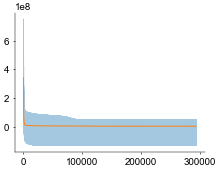

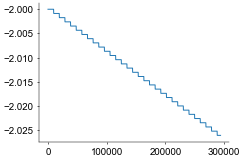

In [58]:
batches = len(results['losses']['train_loss_batches'])
epochs = len(results['losses']['train_loss_epochs'])
delta_be = batches // epochs

plt.plot(np.arange(batches), results['losses']['train_loss_batches'], alpha=0.4)
plt.plot(delta_be*np.arange(epochs), results['losses']['train_loss_epochs'])
plt.show()

plt.plot(np.log10(results['lrs']))
plt.show()

In [61]:
evalsteps = 120
num_samps = 20
N = observations.shape[0]
x_dims = model.inp_model.x_dims

cisi_t_eval = jnp.linspace(0.0, 3.0, evalsteps)
isi_cond = jnp.ones((N, max_ISI_order-1))
x_cond = jnp.ones(x_dims)


prng_state = jr.PRNGKey(123)


ISI_density = model.obs_model.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=True,
)


mean_ISI = model.obs_model.sample_conditional_ISI_expectation(
    prng_state,
    num_samps,
    lambda x: x,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    f_num_quad_pts=100,
    isi_num_quad_pts=100, 
    prior=True,
)

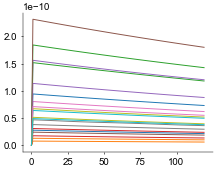

In [62]:
n = 0

plt.plot(ISI_density[:, n, :].T)
plt.show()

In [50]:
jnp.exp(model.obs_model.gp.kernel.kernels[1].kernels[0].pre_len[:, 5])

DeviceArray([         inf,          inf,          inf,          inf,
             8.539925e+37], dtype=float32)

In [51]:
jnp.exp(model.obs_model.log_warp_tau)

DeviceArray([11.642654, 11.337601, 11.345175, 14.082199,  9.404612], dtype=float32)

In [28]:
### evaluation ###
x_evals = 40
y_evals = 40
x_dims = 2

x_eval = jnp.linspace(0, 500, x_evals)
y_eval = jnp.linspace(0, 500, y_evals)
evalsteps = x_eval*y_eval

x_eval, y_eval = np.meshgrid(x_eval, y_eval)
or_shape = x_eval.shape

pos_eval = jnp.stack([x_eval, y_eval], axis=-1).reshape(-1, x_dims)
theta_eval = 0.0 * jnp.ones((pos_eval.shape[0], 1))

sp_locs = model.obs_model.gp.induc_locs
locs_eval = jnp.concatenate((pos_eval, theta_eval), axis=-1)[None, None, ...]


post_mean, post_cov, KL = model.obs_model._gp_posterior(
    locs_eval, mean_only=False, diag_cov=True, compute_KL=True, jitter=1e-8)

neurons = model.obs_model.likelihood.obs_dims

post_mean = post_mean[0].reshape(neurons, *or_shape)
post_var = post_cov[0].reshape(neurons, *or_shape)

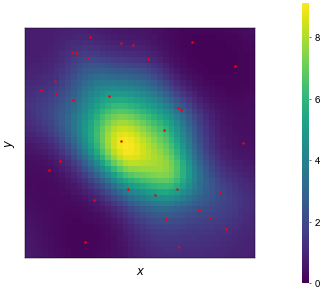

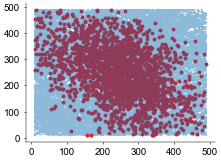

In [34]:
n = 0

link_fn = model.obs_model.likelihood.inverse_link




fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 1])
lib.utils.plots.decorate_ax(ax)  # get all four spines around plot
ax.scatter(sp_locs[n, :, 0], sp_locs[n, :, 1], marker='.', c='r')
im = ax.imshow(link_fn(post_mean[n, ...]), 
           extent=[locs_eval[..., 0].min(), locs_eval[..., 0].max(), 
                   locs_eval[..., 1].min(), locs_eval[..., 1].max()], 
           aspect='equal', origin='lower', cmap='viridis', vmin=0.)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#ax.set_title('noise correlations')


ax = fig.add_subplot(spec[0, 2])
lib.utils.plots.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)


# plt.scatter(sp_locs[n, :, 0], sp_locs[n, :, 1], marker='.', c='r')
# plt.imshow(post_var[n, ...], 
#            extent=[locs_eval[..., 0].min(), locs_eval[..., 0].max(), 
#                    locs_eval[..., 1].min(), locs_eval[..., 1].max()], 
#            aspect='equal', vmin=0., origin='lower', cmap='viridis')
# plt.show()

fig = plt.figure()
n = 0
plt.plot(x_t, y_t, alpha=0.5)
plt.scatter(x_t[spikes[n].astype(bool)], y_t[spikes[n].astype(bool)], c='r')
plt.show()

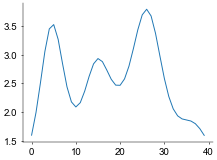

In [92]:
plt.plot(link_fn(post_mean)[n, 25, :])